### Data-vector blinding for the power spectrum multipoles

Example notebook showing how to implement the data-vector level blinding for the galaxy power spectrum multipoles.

In [21]:
import sys
from desiblind import TracerPowerSpectrumMultipolesBlinder

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

sys.path.insert(0, '../scripts')
from fs_likelihood import get_theory, get_tracer_zrange, get_synthetic_data, get_fit_fn


The blinding procedure does the following:

$P_{\rm blind}(k) = P(k) - W(k, k') P_{\rm ref}(k') + W(k, k') P_{\rm shift}(k')$,

where $P_{\rm ref}(k)$ is computed with a *reference* cosmology (reasonably a good match to the data), while 
$P_{\rm shift}(k)$ is computed with a *shift* cosmology (the blinding cosmology).

In [2]:
# We read the reference parameters from a joint full-shape fit to all GQC tracers
from desilike.samples import Profiles, Chain

profiles = Profiles.load(get_fit_fn('profiles'))
#profiles = Profiles.load('../scripts/tests/profiles/profiles_abacushf_fs.npy')
bestfit = profiles.bestfit.choice(index='argmax', input=True)
bestfit = {name: float(value) for name, value in bestfit.items()}

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


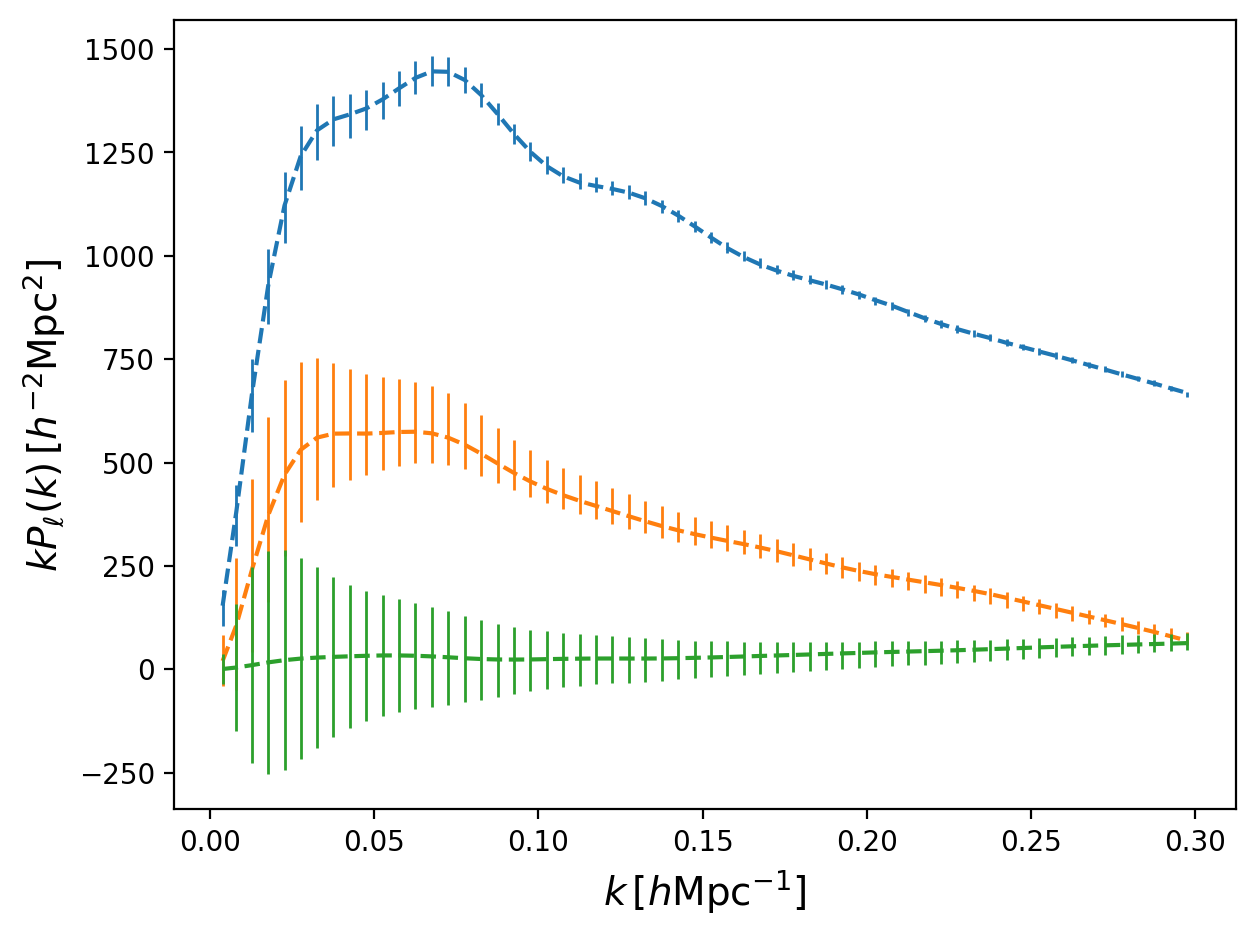

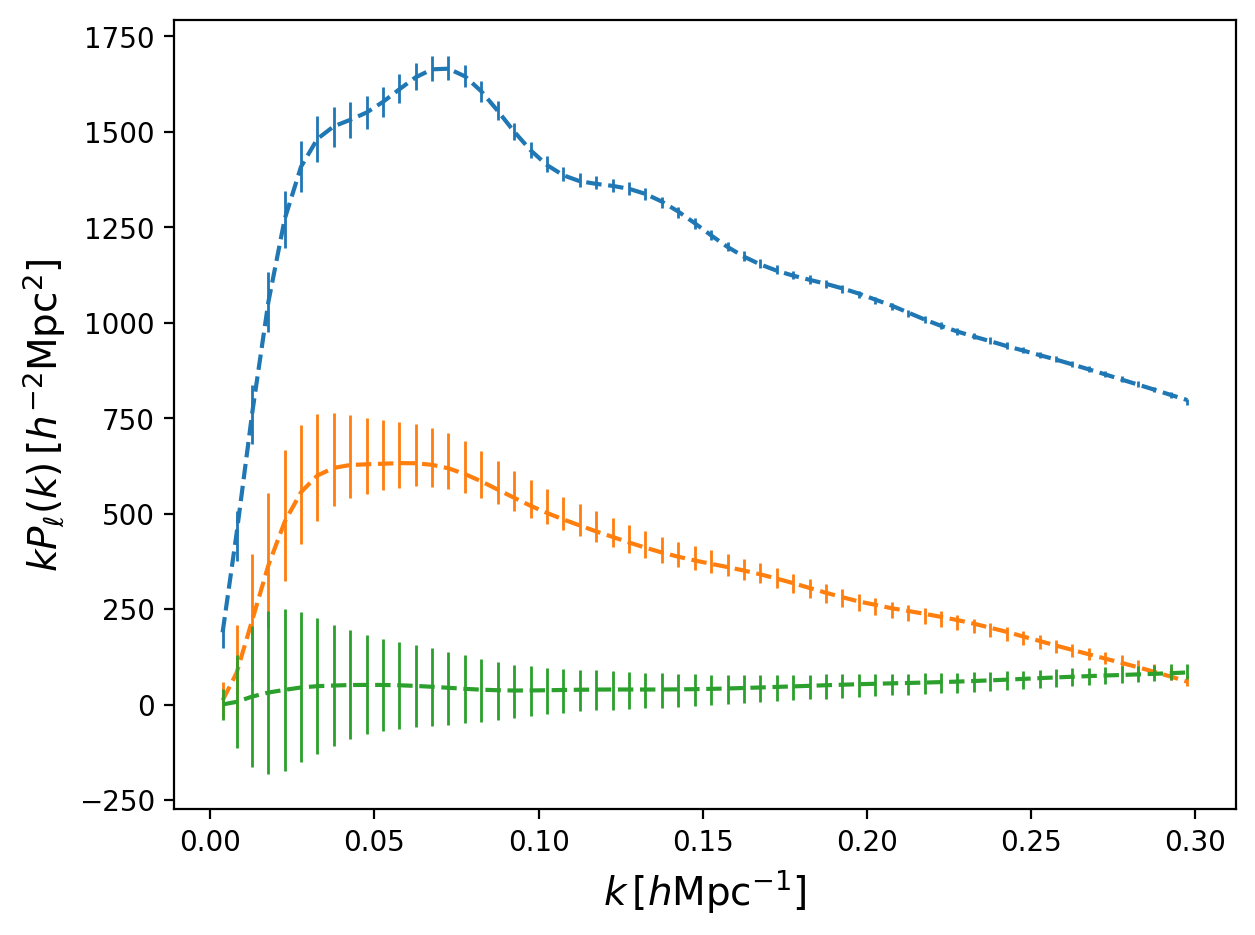

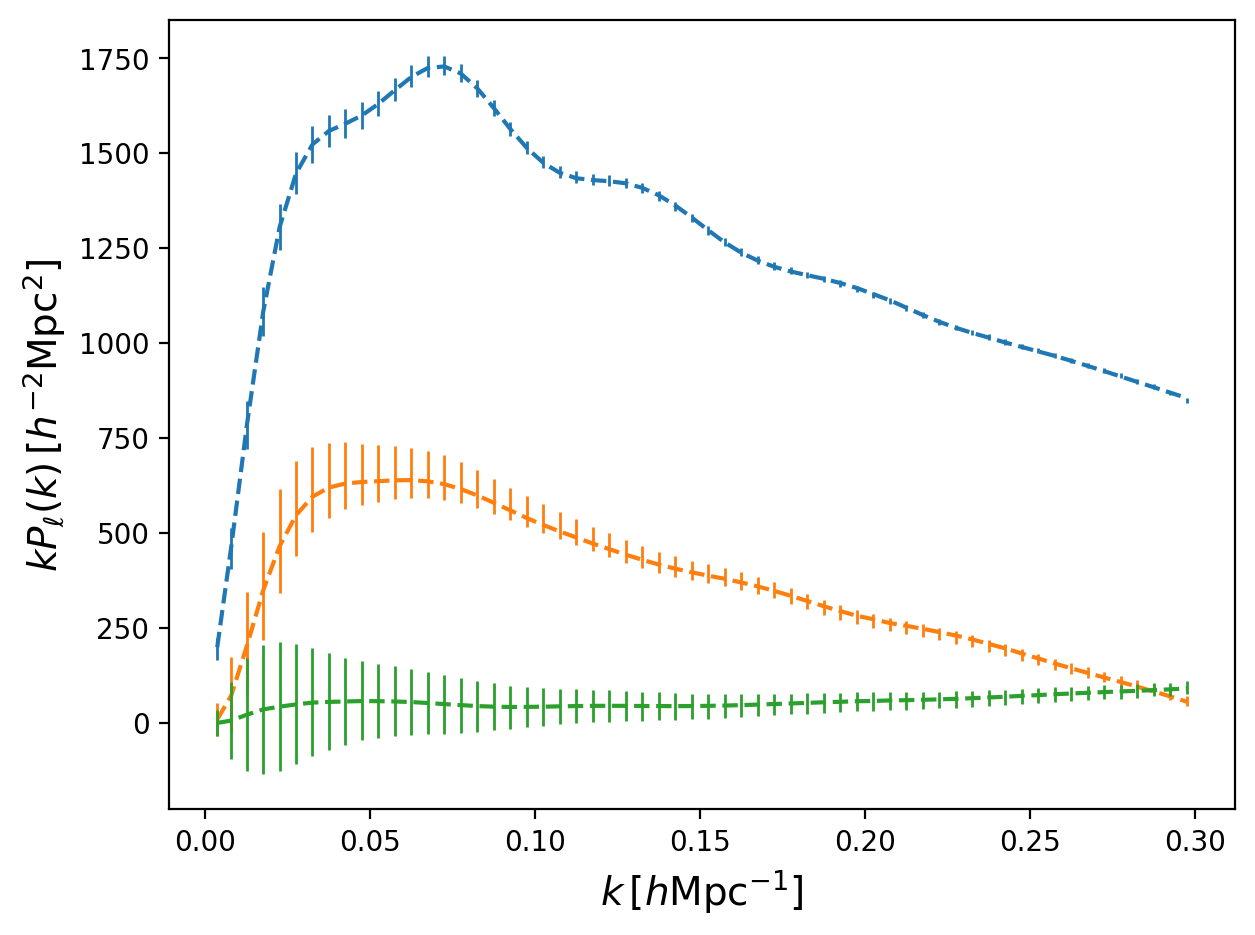

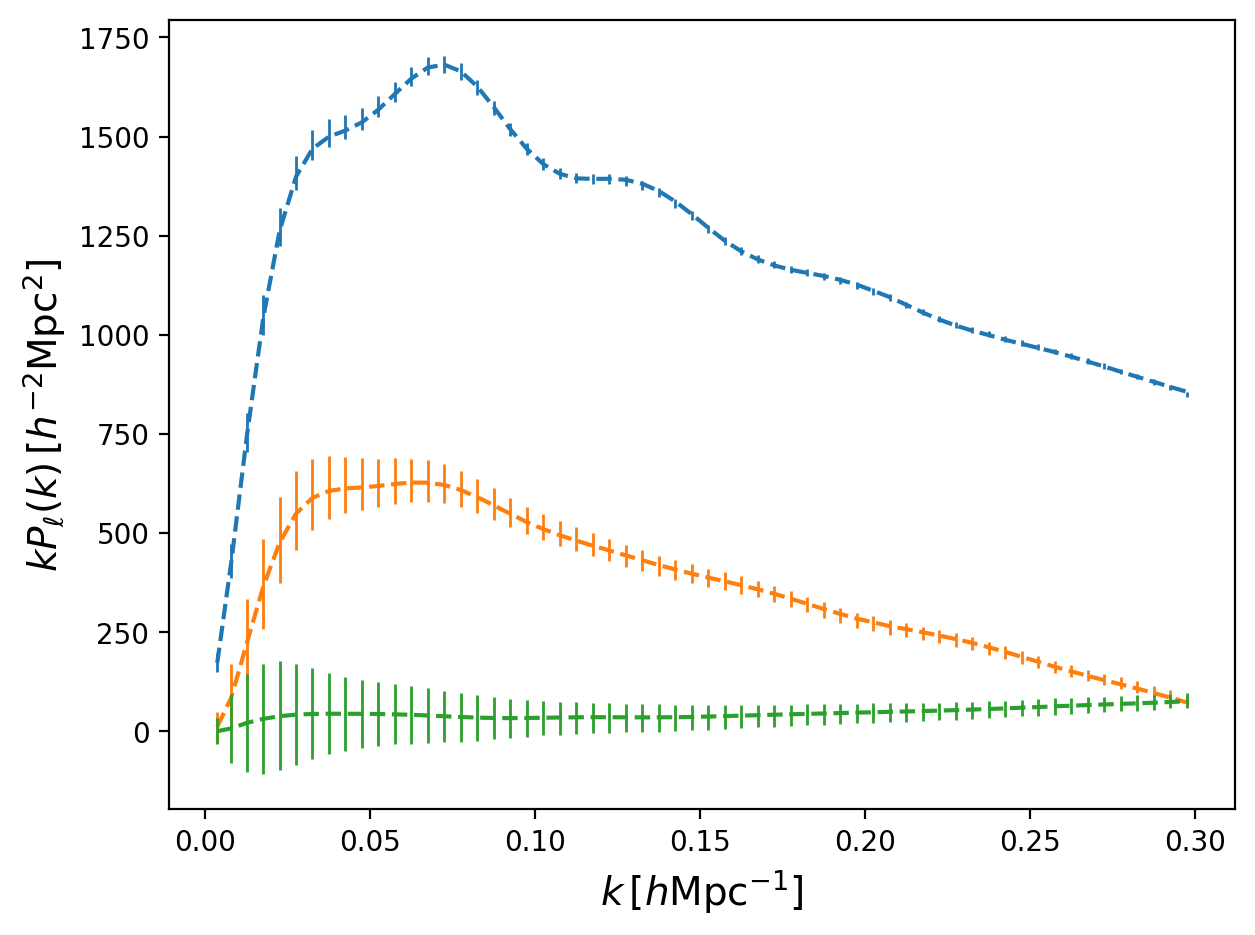

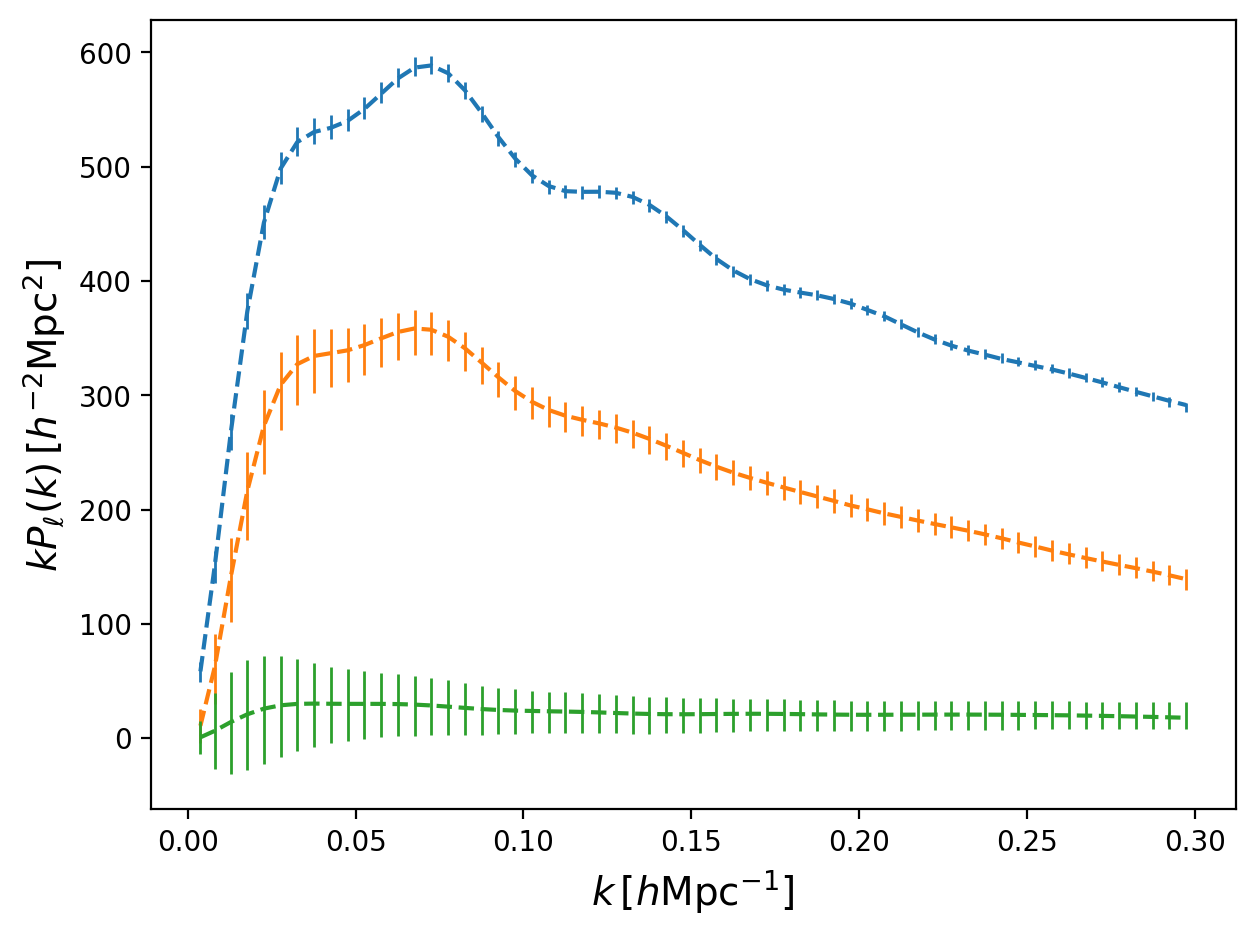

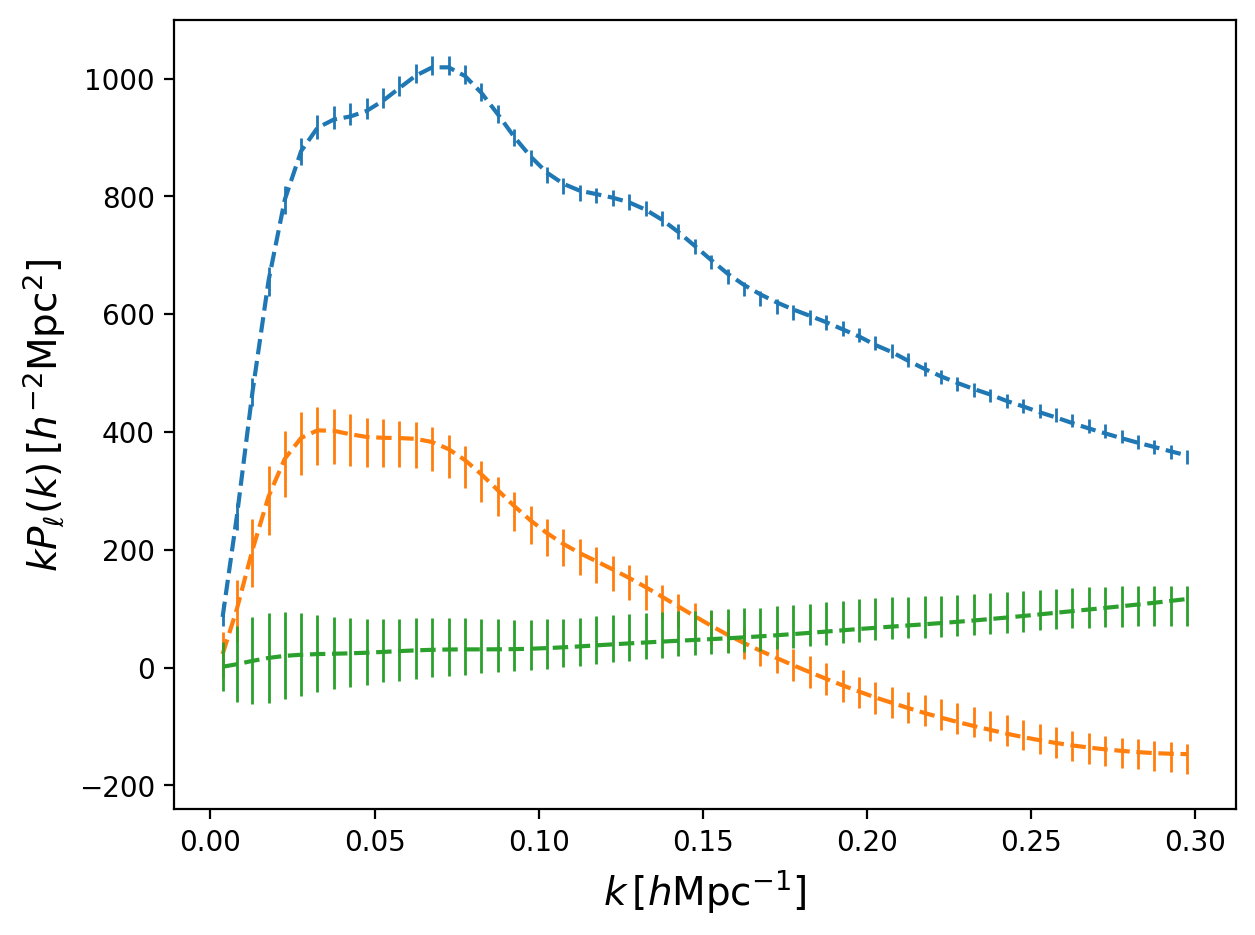

In [3]:
# we instantiate TracerPowerSpectrumMultipolesBlinder, which will provide
# the necessary tools to apply the blinding. We then loop over tracers
# and add their likelihood to the blinder.

cosmo_params = {name: value for name, value in bestfit.items() if '.' not in name}
nuisance_params = {name: value for name, value in bestfit.items() if name not in cosmo_params}

blinder = TracerPowerSpectrumMultipolesBlinder()

tracers = ['BGS_z0', 'LRG_z0', 'LRG_z1', 'LRG_z2', 'ELG_z1', 'QSO_z0']

for namespace in tracers:
    tracer, zrange = get_tracer_zrange(namespace)
    data, covariance, window = get_synthetic_data(tracer=tracer, zrange=zrange, region='GCcomb', ells=[0, 2, 4],
                                                  weights='default_fkp', klim=(0., 0.3), rebin=5)
    theory = get_theory(z=window.theory.get(ells=0).z, tracer='QSO') #tracer)  # FIXME
    theory.init.update(k=window.theory.get(ells=0).coords('k'), shotnoise=data.get(ells=0).values('shotnoise').mean())
    params = cosmo_params | {param.split('.')[-1]: value for param, value in nuisance_params.items() if param.startswith(namespace)}
    spectrum = theory(**params)
    observable = window.dot(np.ravel(spectrum), return_type=None, zpt=False)

    if True:
        ax = plt.gca()
        for ill, ell in enumerate(observable.ells):
            color = f'C{ill:d}'
            pole = observable.get(ells=ell)
            ax.plot(k:=pole.coords('k'), k * pole.value(), color=color, linestyle='--')
            pole = data.get(ells=ell)
            std = covariance.at.observable.get(ells=ell).std()
            ax.errorbar(k:=pole.coords('k'), k * pole.value(), k * std, color=color, ms=2.5, ls='none', elinewidth=1.0)
        ax.set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$', fontsize=14)
        ax.set_ylabel(r'$k P_\ell(k)\,[h^{-2}{\rm Mpc}^{2}]$', fontsize=14)
        plt.tight_layout()
        plt.show()

    blinder.add_observable(name=namespace, data=observable, covariance=covariance)


In [4]:
chain = Chain.concatenate([Chain.load(fn).ravel()[::100] for fn in get_fit_fn('chains')[1:2]])


1.0 inf


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/desilike/lsstypes/lib/python3.10/site-packages/desilike/parameter.py:537: RuntimeWarning: overflow encountered in exp
  new = getattr(ufunc, method)(*input_values, **kwargs)


Removed no burn in


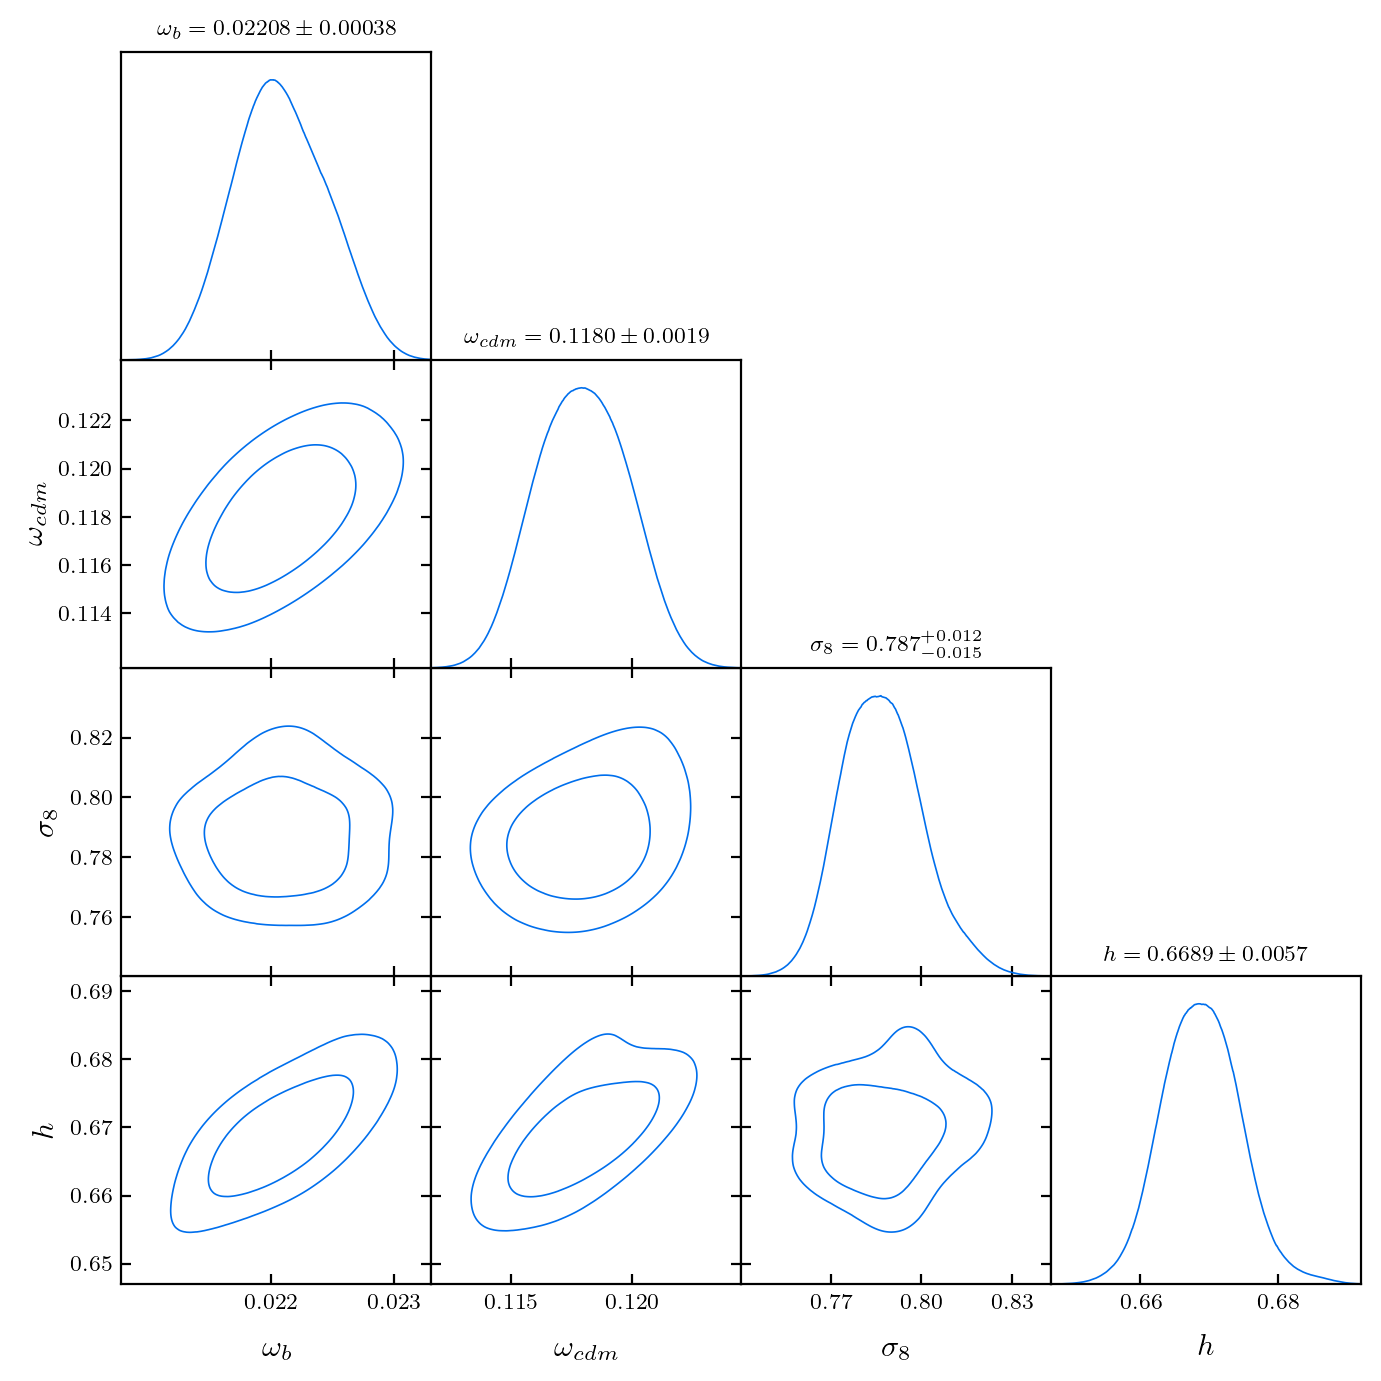

In [24]:
from desilike.samples import plotting
%matplotlib inline

plotting.plot_triangle(chain, params=['omega_b', 'omega_cdm', 'sigma8_m', 'h'], title_limit=1)

# plt.savefig('posterior.pdf')
plt.show()

In [9]:
alpha = 0.5
delta = chain['logposterior'] - chain['logposterior'].max()  # negative if far from MAP
mask = delta > -4.  # select regions where delta logp > -4.
delta = delta[mask]
chain = chain[mask]
p = np.exp(- alpha * delta)  # upweight far from MAP

In [28]:
rng = np.random.RandomState(seed=42)

# randomly draw 20 samples from the posterior
idx = rng.choice(np.arange(len(chain)), size=20, p=p / p.sum(), replace=False)
posterior_samples = chain[idx].sample_solved()

In [ ]:
# we now apply the blinding to each tracer. the "blinded_data" are provided
# to the .set_blinded_data method.

for namespace in tracers:
    tracer, zrange = get_tracer_zrange(namespace)
    data, covariance, window = get_synthetic_data(tracer=tracer, zrange=zrange, region='GCcomb', ells=[0, 2, 4],
                                                  weights='default_fkp', klim=(0., 0.3), rebin=5)
    theory = get_theory(z=window.theory.get(ells=0).z, tracer=tracer)
    theory.init.update(k=window.theory.get(ells=0).coords('k'), shotnoise=data.get(ells=0).values('shotnoise').mean())

    for i in range(len(posterior_samples)):
        sample = posterior_samples[i].to_dict(params=posterior_samples.params(input=True))
        cosmo_params = {name: float(value) for name, value in sample.items() if '.' not in name}
        nuisance_params = {name: float(value) for name, value in sample.items() if name not in cosmo_params}
        params = cosmo_params | {param.split('.')[-1]: value for param, value in nuisance_params.items() if param.startswith(namespace)}
        spectrum = theory(**params)
        observable = window.dot(np.ravel(spectrum), return_type=None, zpt=False)
        blinder.set_blinded_data(namespace, blinded_data=observable)

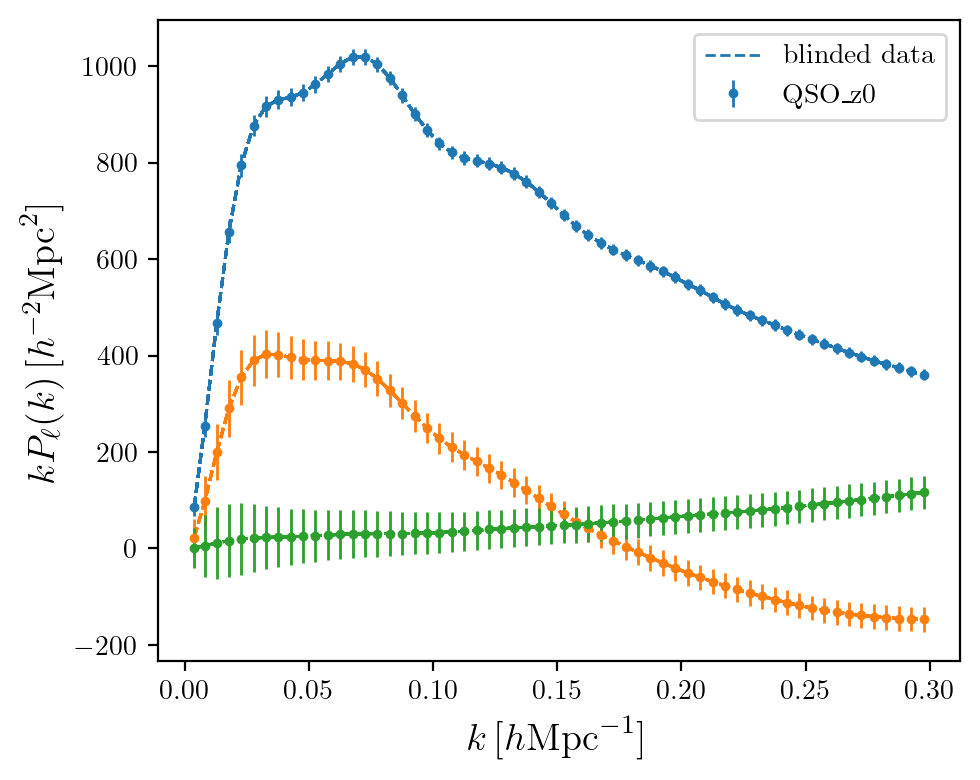

In [39]:
# we can plot the original and blinded data, together with the reference theory.
# blinded_ids specify which blinding realization we want to show
fig, ax = blinder.plot_observables(name='QSO_z0', show_blinded=True, blinded_ids=list(range(20)))
plt.show()

In [36]:
# we save the shifts that are needed to blind the measurements to disk.
# this will then allow us to use those shifts to blind any input data
# without having to go through all the trouble we set up above
blinder.write_blinded_shifts()

In [37]:
# load the shifts and use a high-level method that blinds input data.

ells = [0, 2, 4]
observable, covariance, window = get_synthetic_data(
    tracer='QSO',
    zrange=(0.8, 2.1),
    region='GCcomb',
    ells=ells
)

poles = [observable.get(ell) for ell in ells]
k = poles[0].coords('k')
poles = [pole.value() for pole in poles]

blinded_data = TracerPowerSpectrumMultipolesBlinder.apply_blinding(
    name='QSO_z0',  # TODO add an internal function so that the user only needs to pass tracer name, zmin, zmax?
    k=k,
    data=poles,
    ells=ells,
)
blinded_data2 = TracerPowerSpectrumMultipolesBlinder.apply_blinding(
    name='QSO_z0',
    data=observable,
)
assert np.allclose(blinded_data2.value(), np.ravel(blinded_data))

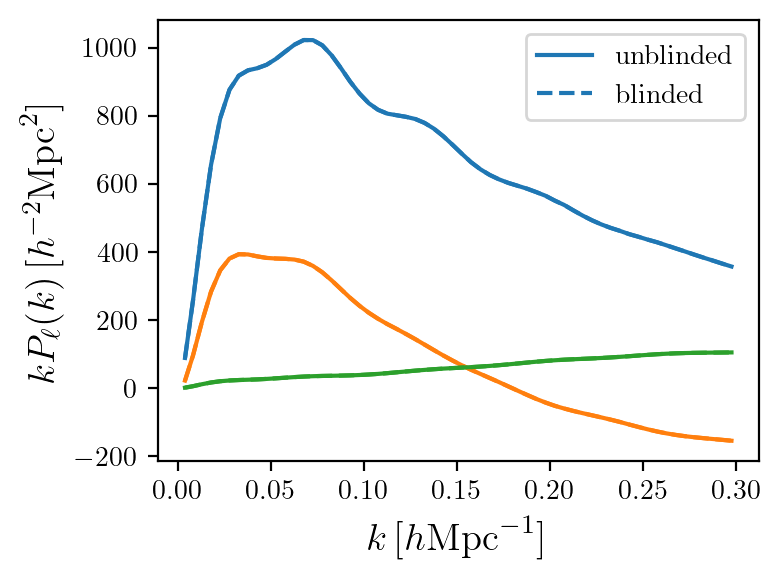

In [38]:
# let's plot it

fig, ax = plt.subplots(figsize=(4, 3))

for ill, ell in enumerate(ells):
    color = f'C{ill}'
    ax.plot(k, k * poles[ill], label='unblinded' if ill == 0 else None, color=color)
    ax.plot(k, k * blinded_data[ill], label='blinded' if ill == 0 else None, color=color, ls='--')

ax.legend()
ax.set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$k P_\ell(k)\,[h^{-2}{\rm Mpc}^{2}]$', fontsize=14)
plt.tight_layout()
plt.show()